# GRU (known + MLP prediction)

In [1]:
import pandas as pd

In [7]:
def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df
get_data()

,usability_positive,design features_negative,general_neutral,price_positive,quality_positive,operation performance_negative,operation performance_positive,general_negative,design features_positive,general_positive,quality_negative,known,to_predict,predictions
0,0.058824,0.029412,0.000000,0.088235,0.147059,0.058824,0.205882,0.176471,0.264706,0.676471,0.117647,0.37,-1,-1
1,0.055556,0.083333,0.000000,0.055556,0.250000,0.111111,0.138889,0.166667,0.166667,0.666667,0.111111,-0.19,-1,-1
2,0.035714,0.000000,0.000000,0.107143,0.285714,0.035714,0.178571,0.178571,0.178571,0.714286,0.035714,-0.04,1,1
3,0.038462,0.000000,0.038462,0.115385,0.307692,0.076923,0.230769,0.038462,0.269231,0.653846,0.000000,0.01,-1,-1
4,0.052632,0.078947,0.000000,0.105263,0.210526,0.078947,0.105263,0.105263,0.184211,0.763158,0.078947,-0.14,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.045455,0.000000,0.000000,0.227273,0.318182,0.181818,0.181818,0.090909,0.136364,0.590909,0.136364,-0.17,-1,1
99,0.055556,0.000000,0.000000,0.277778,0.277778,0.000000,0.222222,0.055556,0.055556,0.833333,0.000000,-0.04,1,1
100,0.037037,0.037037,0.000000,0.074074,0.222222,0.074074,0.185185,0.111111,0.148148,0.592593,0.037037,0.12,1,-1
101,0.034483,0.137931,0.000000,0.068966,0.379310,0.034483,0.275862,0.103448,0.137931,0.724138,0.068966,0.01,-1,-1


In [8]:
get_data().columns

Index(['usability_positive', 'design features_negative', 'general_neutral',
       'price_positive', 'quality_positive', 'operation performance_negative',
       'operation performance_positive', 'general_negative',
       'design features_positive', 'general_positive', 'quality_negative',
       'known', 'to_predict', 'predictions'],
      dtype='object')

## 0. GRU with only stock price diff

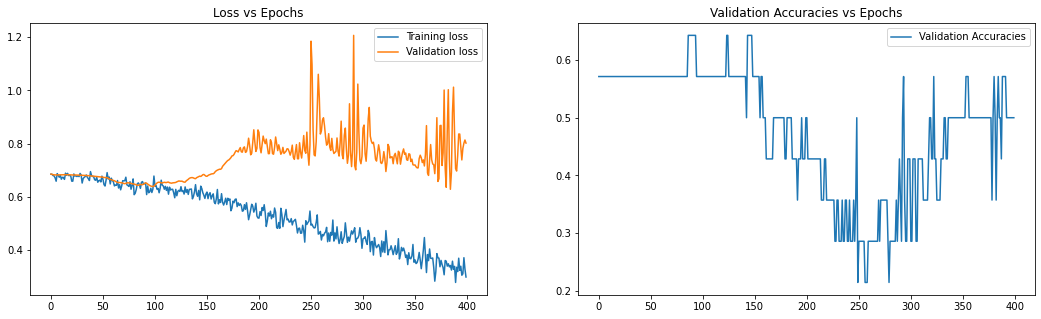

IntSlider(value=7, description='Look Back:', max=7, min=3)

Dropdown(description='Hidden Size:', index=1, options=(16, 32), value=32)

In [85]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back-1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['known']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            model = GRUModel(1, hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs), desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss = evaluate(model, test_dataloader, criterion)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))
    
    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]
    
    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output

def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader,_,_ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)

df = get_data()
look_backs = [3, 4, 5, 6, 7]
hidden_sizes = [16, 32]
num_epochs = 400
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



## 1. GRU with 2 dim features (known + MLP predict)

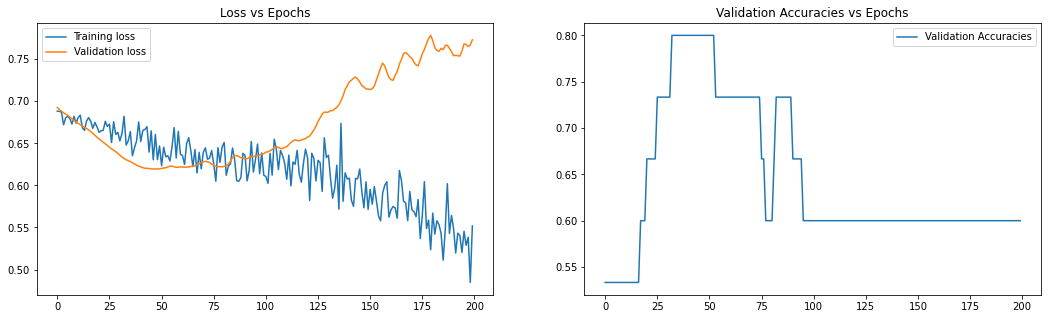

IntSlider(value=6, description='Look Back:', max=7, min=3)

Dropdown(description='Hidden Size:', index=1, options=(16, 32), value=32)

In [73]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back-1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['known', 'predictions']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            model = GRUModel(2, hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs), desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss = evaluate(model, test_dataloader, criterion)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))
    
    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]
    
    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output

def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader,_,_ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)

df = get_data()
look_backs = [3, 4, 5, 6, 7]
hidden_sizes = [16, 32]
num_epochs = 200
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



## 2. GRU with known + (instruction modulated reset gate)

In [77]:
get_data().columns

Index(['usability_positive', 'design features_negative', 'general_neutral',
       'price_positive', 'quality_positive', 'operation performance_negative',
       'operation performance_positive', 'general_negative',
       'design features_positive', 'general_positive', 'quality_negative',
       'known', 'to_predict', 'predictions'],
      dtype='object')

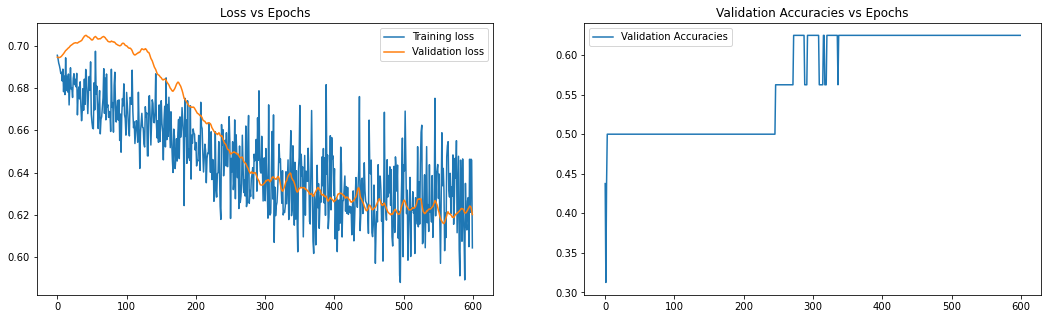

IntSlider(value=5, description='Look Back:', max=7, min=5)

Dropdown(description='Hidden Size:', index=1, options=(4, 8, 16), value=8)

In [86]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


# CustomGRUCellWithInstruction and InstructionModulatedGRU as defined earlier
class CustomGRUCellWithInstruction(nn.Module):
    def __init__(self, input_size, hidden_size, instruction_size):
        super(CustomGRUCellWithInstruction, self).__init__()

        self.hidden_size = hidden_size
        self.update_gate = nn.Sequential(
            nn.Linear(input_size + hidden_size - 1 , hidden_size),
            nn.Sigmoid()
        )# -1 for instruction
        self.reset_gate = nn.Sequential(
            nn.Linear((input_size-1) + hidden_size + instruction_size, hidden_size), # -1 for instruction
            nn.Sigmoid()
        )
        self.candidate_hidden_state = nn.Sequential(
            nn.Linear((input_size-1) + hidden_size, hidden_size), # -1 for instruction
            nn.Tanh()
        )

    def forward(self, x, h_prev, instruction):
        combined = torch.cat((x, h_prev), dim=1)
        combined_with_instruction = torch.cat((combined, instruction), dim=1)
        update = self.update_gate(combined)
        reset = self.reset_gate(combined_with_instruction)
        candidate_h = self.candidate_hidden_state(torch.cat((x, reset * h_prev), dim=1))
        h_new = (1 - update) * h_prev + update * candidate_h

        return h_new


class InstructionModulatedGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(InstructionModulatedGRU, self).__init__()

        self.hidden_size = hidden_size
        self.gru_cell = CustomGRUCellWithInstruction(input_size, hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        instruction = x[:, -1, -1].unsqueeze(1)  # Extract the instruction from the input
        x = x[:, :, :-1]  # Remove the instruction from the input
        h = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        for t in range(x.size(1)):
            h = self.gru_cell(x[:, t, :], h, instruction)

        out = self.fc(h)
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back - 1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['known', 'predictions']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
#             print('111')
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            # Instantiate InstructionModulatedGRU instead of GRUModel
            model = InstructionModulatedGRU(input_size=2, hidden_size=hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs),
                              desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

                train_losses.append(train_loss)
                val_losses.append((val_loss, val_accuracy))

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))

    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]

    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output


def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader, _, _ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)


df = get_data()
look_backs = [5, 6, 7]
hidden_sizes = [4,8,16]
num_epochs = 600
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



## 2.1 Instruction-Modulated Upate

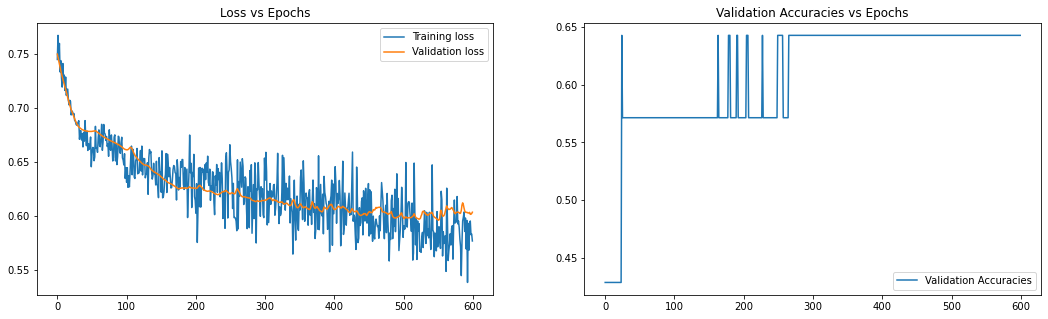

IntSlider(value=7, description='Look Back:', max=7, min=5)

Dropdown(description='Hidden Size:', index=1, options=(4, 8, 16), value=8)

In [84]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


# CustomGRUCellWithInstruction and InstructionModulatedGRU as defined earlier
class CustomGRUCellWithInstruction(nn.Module):
    def __init__(self, input_size, hidden_size, instruction_size):
        super(CustomGRUCellWithInstruction, self).__init__()

        self.hidden_size = hidden_size
        self.update_gate = nn.Sequential(
            nn.Linear((input_size-1) + hidden_size + instruction_size, hidden_size), # -1 for instruction
#             nn.Linear(input_size + hidden_size - 1 , hidden_size),
            nn.Sigmoid()
        )# -1 for instruction
        self.reset_gate = nn.Sequential(
#             nn.Linear((input_size-1) + hidden_size + instruction_size, hidden_size), # -1 for instruction
            nn.Linear(input_size + hidden_size - 1 , hidden_size),
            nn.Sigmoid()
        )
        self.candidate_hidden_state = nn.Sequential(
            nn.Linear((input_size-1) + hidden_size, hidden_size), # -1 for instruction
            nn.Tanh()
        )

    def forward(self, x, h_prev, instruction):
        combined = torch.cat((x, h_prev), dim=1)
        combined_with_instruction = torch.cat((combined, instruction), dim=1)
#         update = self.update_gate(combined)
#         reset = self.reset_gate(combined_with_instruction)
        
        update = self.update_gate(combined_with_instruction)
        reset = self.reset_gate(combined)
        
        candidate_h = self.candidate_hidden_state(torch.cat((x, reset * h_prev), dim=1))
        h_new = (1 - update) * h_prev + update * candidate_h

        return h_new


class InstructionModulatedGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(InstructionModulatedGRU, self).__init__()

        self.hidden_size = hidden_size
        self.gru_cell = CustomGRUCellWithInstruction(input_size, hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        instruction = x[:, -1, -1].unsqueeze(1)  # Extract the instruction from the input
        x = x[:, :, :-1]  # Remove the instruction from the input
        h = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        for t in range(x.size(1)):
            h = self.gru_cell(x[:, t, :], h, instruction)

        out = self.fc(h)
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back - 1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['known', 'predictions']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
#             print('111')
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            # Instantiate InstructionModulatedGRU instead of GRUModel
            model = InstructionModulatedGRU(input_size=2, hidden_size=hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs),
                              desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

                train_losses.append(train_loss)
                val_losses.append((val_loss, val_accuracy))

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))

    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]

    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output


def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader, _, _ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)


df = get_data()
look_backs = [5, 6, 7]
hidden_sizes = [4,8,16]
num_epochs = 600
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



# GRU (ABSA)

## 3. ABSA only

In [55]:
len(['usability_positive', 'design features_negative', 'general_neutral',
            'price_positive', 'quality_positive', 'operation performance_negative',
            'operation performance_positive', 'general_negative',
            'design features_positive', 'general_positive', 'quality_negative'])

11

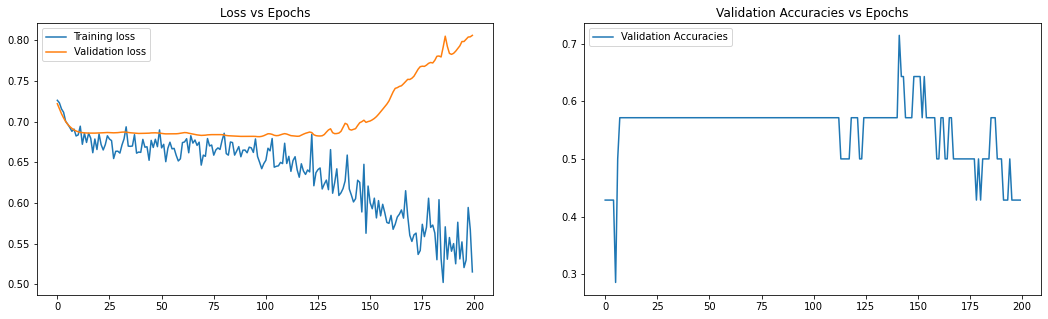

IntSlider(value=7, description='Look Back:', max=7, min=3)

Dropdown(description='Hidden Size:', options=(16, 32), value=16)

In [74]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back-1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['usability_positive', 'design features_negative', 'general_neutral',
            'price_positive', 'quality_positive', 'operation performance_negative',
            'operation performance_positive', 'general_negative',
            'design features_positive', 'general_positive', 'quality_negative']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            model = GRUModel(11, hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs), desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss = evaluate(model, test_dataloader, criterion)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))
    
    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]
    
    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output

def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader,_,_ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)

df = get_data()
look_backs = [3, 4, 5, 6, 7]
hidden_sizes = [16, 32]
num_epochs = 200
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



## 4. ABSA + known

In [87]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
import torch.nn.functional as F


def get_data():
    df = pd.read_csv('./data/6505_MLP_predicted_movement.csv', index_col=[0])
    return df


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


class CustomDataset(Dataset):
    def __init__(self, X, y, look_back):
        self.X = [X[i:i + look_back] for i in range(len(X) - look_back)]
        self.y = y[look_back-1:-1]
        self.y = np.where(self.y == -1, 0, self.y)  # Map -1 to 0
        self.look_back = look_back

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def preprocessing(df, look_back):
    X = df[['usability_positive', 'design features_negative', 'general_neutral',
            'price_positive', 'quality_positive', 'operation performance_negative',
            'operation performance_positive', 'general_negative',
            'design features_positive', 'general_positive', 'quality_negative', 'known']].values
    y = df['to_predict'].values

    X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
    y_train, y_test = y[:int(len(X) * 0.8)], y[int(len(X) * 0.8):]

    return X_train, X_test, y_train, y_test


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    accuracy = accuracy_score(all_targets, all_preds)
    return running_loss / len(dataloader), accuracy


def train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = {}
    for look_back in look_backs:
        for hidden_size in hidden_sizes:
            X_train, X_test, y_train, y_test = preprocessing(df, look_back)
            train_dataset = CustomDataset(X_train, y_train, look_back)
            test_dataset = CustomDataset(X_test, y_test, look_back)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

            model = GRUModel(12, hidden_size)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_losses = list()
            val_losses = list()

            for epoch in tqdm(range(num_epochs), desc=f'Training model with lookback {look_back}, hidden size {hidden_size}'):
                train_loss = train(model, train_dataloader, criterion, optimizer)
                val_loss = evaluate(model, test_dataloader, criterion)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)

            all_models[(look_back, hidden_size)] = (model, train_dataloader, test_dataloader, train_losses, val_losses)

    return all_models


def plot_results(look_back, hidden_size, all_models, all_results):
    model, train_dataloader, test_dataloader, train_losses, val_losses = all_models[(look_back, hidden_size)]
    criterion = nn.CrossEntropyLoss()

    train_loss, train_accuracy = evaluate(model, train_dataloader, criterion)
    val_loss, val_accuracy = evaluate(model, test_dataloader, criterion)

    clear_output(wait=True)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 5))
    
    losses = [item[0] for item in val_losses]
    accuracies = [item[1] for item in val_losses]
    
    ax0.plot(train_losses, label='Training loss')
    ax0.plot(losses, label='Validation loss')
    ax0.set_title('Loss vs Epochs')
    ax0.legend()

    ax1.plot(accuracies, label='Validation Accuracies')
    ax1.set_title('Validation Accuracies vs Epochs')
    ax1.legend()

    plt.show()


from IPython.display import display, clear_output

def interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr):
    all_models = train_all_models(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)

    all_results = {}
    for look_back, hidden_size in all_models:
        _, _, test_dataloader,_,_ = all_models[(look_back, hidden_size)]
        criterion = nn.CrossEntropyLoss()
        _, val_accuracy = evaluate(all_models[(look_back, hidden_size)][0], test_dataloader, criterion)
        all_results[(look_back, hidden_size)] = val_accuracy

    look_back_slider = widgets.IntSlider(min=min(look_backs), max=max(look_backs), step=1, description='Look Back:')
    hidden_size_slider = widgets.Dropdown(options=hidden_sizes, description='Hidden Size:')

    def on_value_change(change):
        clear_output(wait=True)
        look_back = look_back_slider.value
        hidden_size = hidden_size_slider.value
        plot_results(look_back, hidden_size, all_models, all_results)
        display(look_back_slider, hidden_size_slider)

    look_back_slider.observe(on_value_change, names='value')
    hidden_size_slider.observe(on_value_change, names='value')

    display(look_back_slider, hidden_size_slider)

df = get_data()
look_backs = [3, 4, 5, 6, 7, 8, 9]
hidden_sizes = [16, 32, 64, 128]
num_epochs = 700
batch_size = 32
lr = 0.001

interactive_plot(df, look_backs, hidden_sizes, num_epochs, batch_size, lr)



Training model with lookback 9, hidden size 128: 100%|██████████| 700/700 [00:15<00:00, 46.48it/s]


IntSlider(value=3, description='Look Back:', max=9, min=3)

Dropdown(description='Hidden Size:', options=(16, 32, 64, 128), value=16)